In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === Base directory ===
base_path = Path(
    r"C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\yaw"
)

# === Collect all *_m.csv files ===
csv_files = sorted(base_path.glob("*_m.csv"))
if not csv_files:
    raise FileNotFoundError(f"No *_m.csv files found in {base_path}")

print(f"📂 Found {len(csv_files)} merged datasets in '{base_path.name}':")
for f in csv_files:
    print("  •", f.name)

# === Utility: detect time column automatically ===
def get_time_col(df):
    for candidate in ["time_s", "syn.time.stamp", "time", "timestamp"]:
        if candidate in df.columns:
            return candidate
    raise ValueError("No time column found.")

📂 Found 5 merged datasets in 'yaw':
  • rosbag2_2025_09_10-10_03_46_m.csv
  • rosbag2_2025_09_10-10_04_18_m.csv
  • rosbag2_2025_09_10-10_04_48_m.csv
  • rosbag2_2025_09_10-10_05_20_m.csv
  • rosbag2_2025_09_10-10_05_49_m.csv


In [29]:
datasets = {}  # dict: name → (time, yaw_rate, thruster)

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    time_col = get_time_col(df)
    t = df[time_col].to_numpy(float)

    # --- Build thruster scalar (sum abs of *_N) ---
    thruster_cols = [c for c in df.columns if c.endswith("_N")]
    if thruster_cols:
        thruster_abs = df[thruster_cols].abs().sum(axis=1)
    else:
        thruster_abs = np.full_like(t, np.nan)

    # --- Compute yaw rate (deg/s → rad/s or from yaw_deg) ---
    if "yaw_rate_deg_s" in df.columns:
        yaw_rate_rad_s = np.deg2rad(df["yaw_rate_deg_s"].to_numpy())
    elif "yaw_deg" in df.columns:
        yaw_rad = np.deg2rad(df["yaw_deg"].to_numpy())
        dt = np.gradient(t)
        dy = np.gradient(np.unwrap(yaw_rad))
        yaw_rate_rad_s = np.where(dt != 0.0, dy / dt, np.nan)
    else:
        yaw_rate_rad_s = np.full_like(t, np.nan)

    datasets[csv_file.stem] = {"t": t, "thruster": thruster_abs, "yaw_rate": yaw_rate_rad_s}

print(f"✅ Loaded {len(datasets)} datasets into memory.")

✅ Loaded 5 datasets into memory.


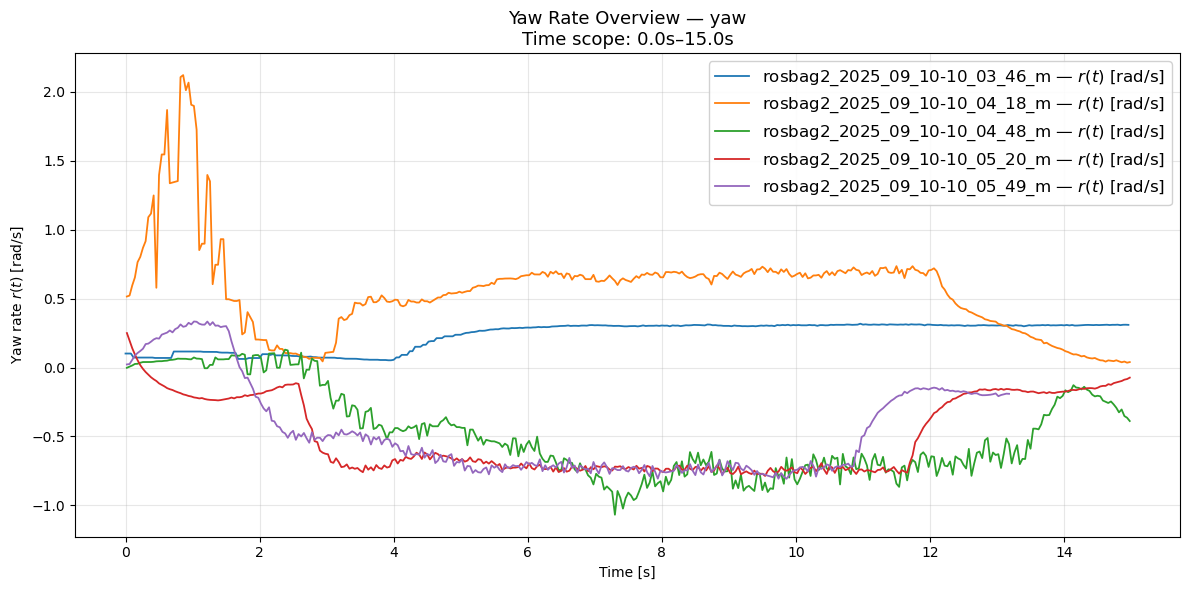

In [30]:
# === Time window for all datasets ===
t_start = 0     # [s] start time
t_end   = 15    # [s] end time

fig, ax = plt.subplots(figsize=(12, 6))

# === Plot yaw rates from all datasets in time window ===
for name, data in datasets.items():
    t = data["t"]
    r = data["yaw_rate"]
    mask = (t >= t_start) & (t <= t_end)
    ax.plot(t[mask], r[mask], linewidth=1.3, label=f"{name} — $r(t)$ [rad/s]")

# === Labels & styling ===
ax.set_title(
    f"Yaw Rate Overview — {base_path.name}\nTime scope: {t_start:.1f}s–{t_end:.1f}s",
    fontsize=13
)
ax.set_xlabel("Time [s]")
ax.set_ylabel(r"Yaw rate $r(t)$ [rad/s]")
ax.legend(loc="upper right", fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


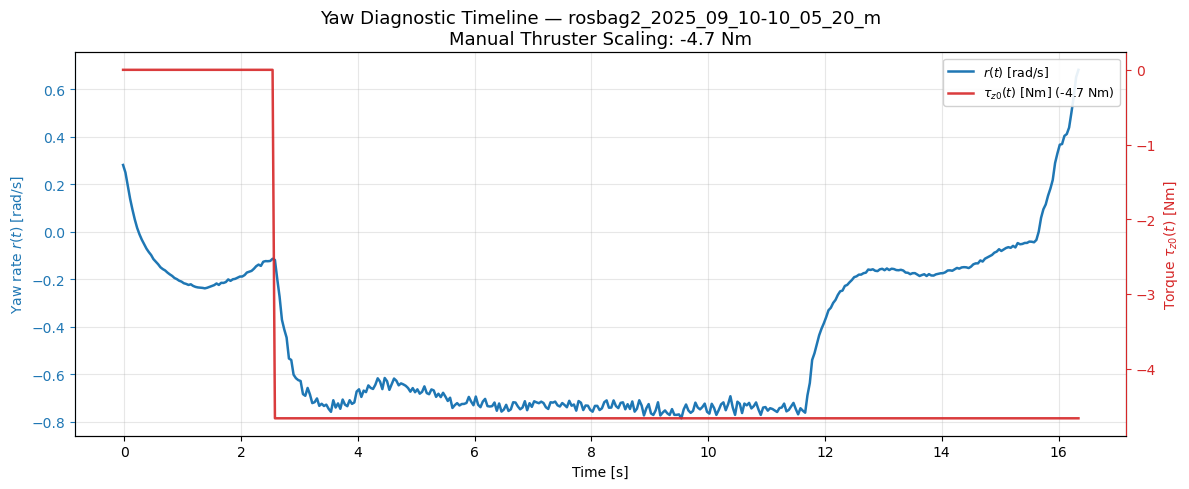

In [31]:
# =======================================================
# 🔍 Step 4 — Detailed Timeline of Selected Dataset [Yaw]
# =======================================================

# === Choose which dataset to inspect ===
selected_name = "rosbag2_2025_09_10-10_05_20_m"   # 👈 change here
manual_thruster_value = -4.664   # [Nm] with a radius of 0.424m and a thrust of 5.5N each

if selected_name not in datasets:
    raise KeyError(f"Dataset '{selected_name}' not found. Available: {list(datasets.keys())}")

data = datasets[selected_name]

# === Load signals ===
t = data["t"]
r = data["yaw_rate"]          # yaw rate r(t)
tau_z0 = data["thruster"]     # measured torque τ_{z0}(t)

# === Use timing from measured torque, but apply manual scaling ===
# Normalize torque to ±1 and scale with manual value
if np.nanmax(np.abs(tau_z0)) > 0:
    tau_z0_scaled = (tau_z0 / np.nanmax(np.abs(tau_z0))) * manual_thruster_value
else:
    tau_z0_scaled = np.zeros_like(tau_z0)

# === Plot ===
fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()

COLOR_YAW = "#1f77b4"   # blue
COLOR_THR = "#d62728"   # red

# --- Plot yaw rate (r) and scaled torque (τ_z0) ---
line1, = ax1.plot(
    t, r,
    color=COLOR_YAW, linewidth=1.8, label=r"$r(t)$ [rad/s]"
)
line2, = ax2.plot(
    t, tau_z0_scaled,
    color=COLOR_THR, linewidth=1.8, alpha=0.9, label=fr"$\tau_{{z0}}(t)$ [Nm] ({manual_thruster_value:.1f} Nm)"
)

# --- Axis labels ---
ax1.set_xlabel("Time [s]")
ax1.set_ylabel(r"Yaw rate $r(t)$ [rad/s]", color=COLOR_YAW)
ax2.set_ylabel(r"Torque $\tau_{z0}(t)$ [Nm]", color=COLOR_THR)

# --- Styling ---
ax1.tick_params(axis="y", colors=COLOR_YAW)
ax2.tick_params(axis="y", colors=COLOR_THR)
ax1.spines["left"].set_color(COLOR_YAW)
ax2.spines["right"].set_color(COLOR_THR)
ax1.grid(True, alpha=0.3)

# --- Legend & Title ---
ax1.legend([line1, line2], [line1.get_label(), line2.get_label()],
            loc="upper right", fontsize=9, framealpha=0.9)


plt.title(
    f"Yaw Diagnostic Timeline — {selected_name}\nManual Thruster Scaling: {manual_thruster_value:.1f} Nm",
    fontsize=13
)

plt.tight_layout()
plt.show()


C:\Users\samue\AppData\Local\Temp\ipykernel_36780\4019292381.py:59: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_pt2, _ = curve_fit(pt2_velocity, t, r, p0=p0_pt2, maxfev=20000)


=== Yaw Fit Results — rosbag2_2025_09_10-10_05_20_m ===
PT2 Model:
  K   = -0.7184
  ωₙ  = 6.7452 rad/s
  ζ   = 1.0000
  t₀  = 2.4495 s

Exponential Model:
  A   = -0.5999
  τ   = 0.1962 s
  t₀  = 2.5988 s
  off = -0.1185

Detected Thruster Activation: 2.540 s
Applied Manual Torque Level: -4.66 Nm
[Angular] Rate source: 'r' -> 'rate_radps'
[Angular] No angle array found; integrated rate -> 'angle_rad'
[Angular] Wrote aliases: 'speed_mps' (rad/s), 'displacement_m' (rad)
[Excel] Wrote C:\Users\samue\Downloads\curvefit_rosbag2_2025_09_10-10_05_20_m_axis_20251027-150427.xlsx (engine='openpyxl')


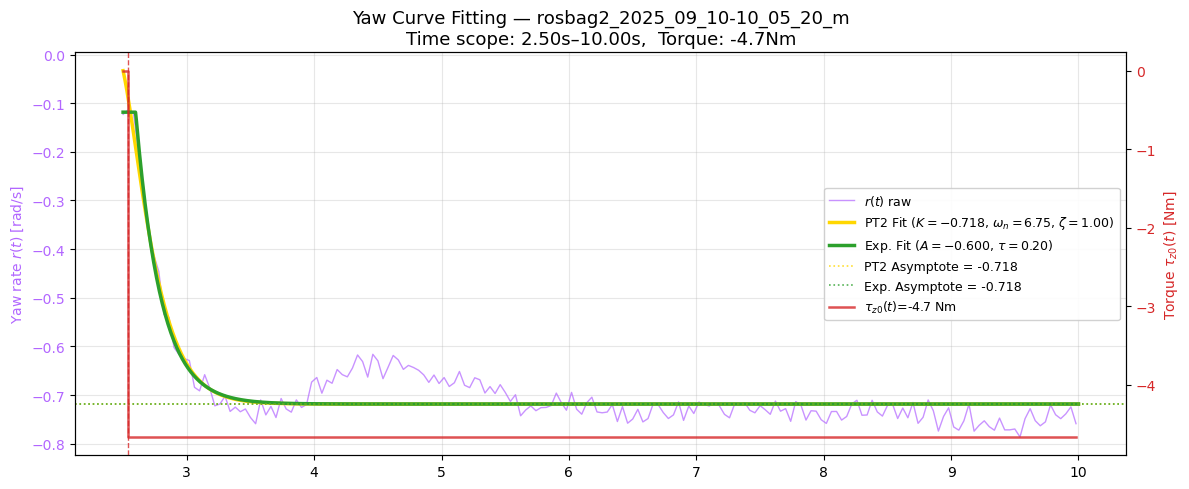

In [32]:
# ==========================================================
# ⚙️ Step 5 — Exponential & PT2 Fit for Yaw (r–τ_{z0})
# ==========================================================

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# === User Inputs ===
t_start = 2.5
t_end   = 10

# === Load dataset ===
data = datasets[selected_name]
t_full = data["t"]
r_full = data["yaw_rate"]       # yaw rate r(t)
tau_z0_full = data["thruster"]  # measured torque τ_{z0}(t)

# === Scope to analysis window ===
mask = (t_full >= t_start) & (t_full <= t_end)
t = t_full[mask]
r = r_full[mask]
tau_z0 = tau_z0_full[mask]

# === Detect thruster activation time directly from data ===
thr_diff = np.gradient(tau_z0)
thruster_x = t[np.argmax(np.abs(thr_diff))]   # time of largest change = activation
thruster_state = np.where(t >= thruster_x, manual_thruster_value, 0.0)

# === Model Definitions ===
def pt2_velocity(t, K, wn, zeta, t0):
    tau = np.maximum(t - t0, 0)
    if np.isclose(zeta, 1.0):
        v = K * (1 - (1 + wn * tau) * np.exp(-wn * tau))
    elif zeta > 1.0:
        s = np.sqrt(zeta**2 - 1)
        lam1, lam2 = -wn * (zeta - s), -wn * (zeta + s)
        A = lam2 / (lam2 - lam1)
        B = -lam1 / (lam2 - lam1)
        v = K * (1 - (A * np.exp(lam1 * tau) + B * np.exp(lam2 * tau)))
    else:
        wd = wn * np.sqrt(1 - zeta**2)
        phi = np.arccos(zeta)
        v = K * (1 - (1 / np.sqrt(1 - zeta**2)) *
                 np.exp(-zeta * wn * tau) *
                 np.sin(wd * tau + phi))
    return v

def exp_growth(t, A, tau, t0, offset):
    tau_rel = np.maximum(t - t0, 0)
    return A * (1 - np.exp(-tau_rel / tau)) + offset

# === Fit both models ===
t0_guess = thruster_x
p0_pt2 = [np.nanmax(r), 2.0, 1.0, t0_guess]
p0_exp = [np.nanmax(r), 1.0, t0_guess, 0.0]

try:
    popt_pt2, _ = curve_fit(pt2_velocity, t, r, p0=p0_pt2, maxfev=20000)
except RuntimeError:
    popt_pt2 = [np.nan] * 4

try:
    popt_exp, _ = curve_fit(exp_growth, t, r, p0=p0_exp, maxfev=20000)
except RuntimeError:
    popt_exp = [np.nan] * 4

# === Results ===
t_ext = np.linspace(t_start, t_end + 0, 1000)
r_fit_pt2 = pt2_velocity(t_ext, *popt_pt2)
r_fit_exp = exp_growth(t_ext, *popt_exp)
steady_pt2 = popt_pt2[0]
steady_exp = popt_exp[0] + popt_exp[3]

print(f"=== Yaw Fit Results — {selected_name} ===")
print("PT2 Model:")
print(f"  K   = {popt_pt2[0]:.4f}")
print(f"  ωₙ  = {popt_pt2[1]:.4f} rad/s")
print(f"  ζ   = {popt_pt2[2]:.4f}")
print(f"  t₀  = {popt_pt2[3]:.4f} s\n")
print("Exponential Model:")
print(f"  A   = {popt_exp[0]:.4f}")
print(f"  τ   = {popt_exp[1]:.4f} s")
print(f"  t₀  = {popt_exp[2]:.4f} s")
print(f"  off = {popt_exp[3]:.4f}\n")
print(f"Detected Thruster Activation: {thruster_x:.3f} s")
print(f"Applied Manual Torque Level: {manual_thruster_value:.2f} Nm")

# === Plot ===
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.grid(True, alpha=0.3)

# --- Yaw rate r(t) + fits ---
violet = "#b266ff"
ax1.plot(t, r, color=violet, lw=1.0, alpha=0.7, label=r"$r(t)$ raw")
ax1.plot(t_ext, r_fit_pt2, color="gold", lw=2.5,
         label=fr"PT2 Fit ($K={popt_pt2[0]:.3f}$, $\omega_n={popt_pt2[1]:.2f}$, $\zeta={popt_pt2[2]:.2f}$)")
ax1.plot(t_ext, r_fit_exp, color="tab:green", lw=2.5,
         label=fr"Exp. Fit ($A={popt_exp[0]:.3f}$, $\tau={popt_exp[1]:.2f}$)")
ax1.axhline(steady_pt2, color="gold", ls=":", lw=1.2, alpha=0.8,
            label=fr"PT2 Asymptote = {steady_pt2:.3f}")
ax1.axhline(steady_exp, color="tab:green", ls=":", lw=1.2, alpha=0.8,
            label=fr"Exp. Asymptote = {steady_exp:.3f}")
ax1.set_ylabel(r"Yaw rate $r(t)$ [rad/s]", color=violet)
ax1.tick_params(axis="y", labelcolor=violet)

# --- Torque τ_{z0}(t) overlay ---
ax2 = ax1.twinx()
ax2.step(t, thruster_state, where="post", color="tab:red", alpha=0.8, lw=1.8,
         label=fr"$\tau_{{z0}}(t)$={manual_thruster_value:.1f} Nm")
ax2.axvline(thruster_x, color="tab:red", ls="--", lw=1.0, alpha=0.8)
ax2.set_ylabel(r"Torque $\tau_{z0}(t)$ [Nm]", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# --- Legend & Title ---
lines, labels = [], []
for ax in fig.axes:
    l, lab = ax.get_legend_handles_labels()
    lines += l
    labels += lab
ax1.legend(lines, labels, loc="right", fontsize=9, framealpha=0.9)

plt.title(
    f"Yaw Curve Fitting — {selected_name}\nTime scope: {t_start:.2f}s–{t_end:.2f}s,  Torque: {manual_thruster_value:.1f}Nm",
    fontsize=13
)
plt.xlabel("Time [s]")
plt.tight_layout()


# ======== Robust Export: works with position OR rate only (linear or angular) ========
from datetime import datetime
from pathlib import Path
import re
import numpy as np
import pandas as pd

def _pick_excel_engine():
    for eng, pkg in (("openpyxl", "openpyxl"), ("xlsxwriter", "XlsxWriter")):
        try:
            __import__(pkg)
            return eng
        except ImportError:
            pass
    return None

def _slugify(s: str) -> str:
    return re.sub(r'[^A-Za-z0-9._-]+', '_', str(s)).strip('_')

def _infer_dataset_name():
    loc = locals() | globals()
    for var in ['selected_name','dataset_name','m','df_name','file_path','source_path','infile','path','filename','real','sim']:
        if var in loc:
            val = loc[var]
            if isinstance(val, (str, Path)):
                s = str(val)
                if any(s.lower().endswith(ext) for ext in ('.csv','.xlsx','.xls','.parquet')):
                    try: s = Path(s).stem
                    except Exception: pass
                return _slugify(s)
    return "dataset"

def _get(name):
    """Return array from current scope if present and 1D."""
    scope = globals()
    if name in scope and scope[name] is not None:
        arr = np.asarray(scope[name])
        if arr.ndim > 0:
            return arr
    return None

def _cumtrapz(y, x):
    """Cumulative trapezoidal integral with initial 0."""
    y = np.asarray(y)
    x = np.asarray(x)
    if len(y) != len(x) or len(y) == 0:
        return None
    out = np.zeros_like(y, dtype=float)
    if len(y) > 1:
        out[1:] = np.cumsum(0.5*(y[1:]+y[:-1])*(x[1:]-x[:-1]))
    return out

# --- Build base dataframe with time in the scoped window 't' ---
df_out = pd.DataFrame({"time_s": t})

# --- Try to find position and/or rate for linear and angular cases ---
# Position candidates (linear)
pos_lin = None
for nm in ["x_b","x","y_b","y","z_b","z"]:
    a = _get(nm)
    if a is not None and len(a) == len(t):
        pos_lin = a; pos_lin_name = nm; break

# Rate candidates (linear)
rate_lin = None
for nm in ["u","v","w","speed_mps","vx","vy","vz","vx_mps","vy_mps","vz_mps"]:
    a = _get(nm)
    if a is not None and len(a) == len(t):
        rate_lin = a; rate_lin_name = nm; break

# Position candidates (angular)
pos_ang = None
for nm in ["psi_b","psi","yaw","theta_b","theta","pitch","phi_b","phi","roll"]:
    a = _get(nm)
    if a is not None and len(a) == len(t):
        pos_ang = a; pos_ang_name = nm; break

# Rate candidates (angular)
rate_ang = None
for nm in ["r","q","p","rate_radps","yaw_rate","pitch_rate","roll_rate"]:
    a = _get(nm)
    if a is not None and len(a) == len(t):
        rate_ang = a; rate_ang_name = nm; break
# Also consider the local variable 'r' you created above (yaw rate in window)
if rate_ang is None and 'r' in globals() and np.ndim(r) > 0 and len(r) == len(t):
    rate_ang = np.asarray(r); rate_ang_name = "r"

# ---- Decide what we actually have and export accordingly ----
did_write = False

# Case A: Angular present (Yaw/Pitch/Roll)
if (pos_ang is not None) or (rate_ang is not None):
    # Prefer rate (rad/s); if only pos exists, differentiate is noisy, so we keep rate as NaN
    if rate_ang is not None:
        df_out["rate_radps"] = rate_ang
        print(f"[Angular] Rate source: '{rate_ang_name}' -> 'rate_radps'")
    else:
        df_out["rate_radps"] = np.nan
        print("[Angular][Warn] No angular rate found (p/q/r); 'rate_radps' set to NaN.")

    # Angle (rad): prefer unwrapped position; if absent, integrate rate
    if pos_ang is not None:
        ang = np.unwrap(pos_ang)
        ang_rel = ang - ang[0]
        df_out["angle_rad"] = ang_rel
        print(f"[Angular] Angle source: '{pos_ang_name}' (unwrapped) -> 'angle_rad'")
    elif rate_ang is not None:
        ang_rel = _cumtrapz(rate_ang, t)
        df_out["angle_rad"] = ang_rel
        print("[Angular] No angle array found; integrated rate -> 'angle_rad'")
    else:
        df_out["angle_rad"] = np.nan

    # Compatibility aliases for downstream code that expects linear names
    df_out["speed_mps"] = df_out["rate_radps"]       # rad/s
    df_out["displacement_m"] = df_out["angle_rad"]   # rad
    print("[Angular] Wrote aliases: 'speed_mps' (rad/s), 'displacement_m' (rad)")
    did_write = True

# Case B: Linear present (Surge/Sway/Heave)
elif (pos_lin is not None) or (rate_lin is not None):
    # Velocity (m/s): prefer direct rate; otherwise differentiate pos is noisy, so keep NaN
    if rate_lin is not None:
        df_out["speed_mps"] = rate_lin
        print(f"[Linear] Velocity source: '{rate_lin_name}' -> 'speed_mps'")
    else:
        df_out["speed_mps"] = np.nan
        print("[Linear][Warn] No linear rate (u/v/w) found; 'speed_mps' set to NaN.")

    # Displacement (m): prefer position; if absent, integrate velocity
    if pos_lin is not None:
        disp = pos_lin - pos_lin[0]
        df_out["displacement_m"] = disp
        print(f"[Linear] Displacement source: '{pos_lin_name}' -> 'displacement_m'")
    elif rate_lin is not None:
        disp = _cumtrapz(rate_lin, t)
        df_out["displacement_m"] = disp
        print("[Linear] No position array found; integrated velocity -> 'displacement_m'")
    else:
        df_out["displacement_m"] = np.nan
    did_write = True

# Case C: Nothing found
if not did_write:
    df_out["speed_mps"] = np.nan
    df_out["displacement_m"] = np.nan
    print("[Warn] No position/rate arrays found for current window; only 'time_s' exported.")

# ---- Save to Excel (CSV fallback) ----
out_dir = Path(r"C:\Users\samue\Downloads")
out_dir.mkdir(parents=True, exist_ok=True)

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
axis_tag = _slugify(axis_name.replace(" ", "_")) if 'axis_name' in globals() else "axis"
dataset_tag = _infer_dataset_name()
out_xlsx = out_dir / f"curvefit_{dataset_tag}_{axis_tag}_{stamp}.xlsx"

engine = _pick_excel_engine()
if engine:
    with pd.ExcelWriter(out_xlsx, engine=engine) as xw:
        df_out.to_excel(xw, index=False, sheet_name="signals")
    print(f"[Excel] Wrote {out_xlsx} (engine='{engine}')")
else:
    out_csv = out_xlsx.with_suffix(".csv")
    df_out.to_csv(out_csv, index=False)
    print(f"[CSV fallback] No Excel engine found. Wrote {out_csv}")
# =======================================================================



plt.show()


In [33]:
# ===============================================================
# === Calculate Fossen yaw parameters from fitted results (r–τz) ===
# ===============================================================

import pandas as pd

# === Known constants ===
tau_z0 = manual_thruster_value   # [Nm] yaw torque step (negative = CW or CCW depending on setup)
Iz     = 0.2457                     # [kg·m²] vehicle moment of inertia about z-axis (replace with actual)
axis   = "Yaw"

# --- Extract fitted values ---
# PT2 Fit parameters
K_pt2, wn_pt2, zeta_pt2, t0_pt2 = popt_pt2
steady_pt2 = K_pt2               # [rad/s]

# Exponential Fit parameters
A_exp, tau_exp, t0_exp, offset_exp = popt_exp
steady_exp = A_exp + offset_exp   # [rad/s]

# === 1️⃣ Exponential (63%) Method ===
r_ss_exp = steady_exp                     # [rad/s]
N_r_exp  = -tau_z0 / r_ss_exp             # [N·m·s/rad]
tau_r_exp = tau_exp                       # [s]
N_rdot_exp = Iz + tau_r_exp * N_r_exp     # [kg·m²]

# === 2️⃣ PT2-based Method ===
# For critical damping (ζ ≈ 1): τ ≈ 1 / (2ζωₙ)
tau_r_pt2 = 1 / (2 * zeta_pt2 * wn_pt2)   # [s]
r_ss_pt2 = steady_pt2                     # [rad/s]
N_r_pt2  = -tau_z0 / r_ss_pt2             # [N·m·s/rad]
N_rdot_pt2 = Iz + tau_r_pt2 * N_r_pt2     # [kg·m²]

# === Summarize results in a clean table ===
df_fossen_yaw = pd.DataFrame({
    "Method": ["Exponential (63%)", "PT2 Fit"],
    "τ_r [s]": [tau_r_exp, tau_r_pt2],
    "N_r [N·m·s/rad]": [N_r_exp, N_r_pt2],
    "N_rdot [kg·m²]": [N_rdot_exp, N_rdot_pt2],
    "Steady-State r_ss [rad/s]": [r_ss_exp, r_ss_pt2],
    "t0 [s]": [t0_exp, t0_pt2]
})

print(f"\n=== Fossen parameter identification for {axis} ===")
display(df_fossen_yaw.round(4))



=== Fossen parameter identification for Yaw ===


,Method,τ_r [s],N_r [N·m·s/rad],N_rdot [kg·m²],Steady-State r_ss [rad/s],t0 [s]
0,Exponential (63%),0.1962,-6.4927,-1.0280,-0.7183,2.5988
1,PT2 Fit,0.0741,-6.4919,-0.2355,-0.7184,2.4495
